# Metrics learning. Практика.

В данном задании нам предстоит кластеризовать клиентов банка по характеру финансового поведения с продуктом банка (кредитная карта). 

## Загрузим необходимые данные и библиотеки

In [148]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings(action='ignore')

In [149]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import Handlers as hd

In [151]:
data = pd.read_csv('data/CC_GENERAL.zip')
data

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## Обработка данных

Посмотрим на статистики, вызвав метод desribe.

In [153]:
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Видим много выбросов, постараемся избавится от них, сделав диапазоны значений для различных колонок.

## Работа с пропусками

In [154]:
data.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [155]:
hd.get_columns_null_info_df(data)

,Column Name,Count Null,% Null,Type
0,CREDIT_LIMIT,1,0.01,float64
1,MINIMUM_PAYMENTS,313,3.50,float64


### Задание 8.1
Выведите количество пропусков. количество пропусков в признаке `MINIMUM_PAYMENTS` используйте как ответ на задание 8.1

In [156]:
data.isnull().sum()['MINIMUM_PAYMENTS']

313

Заполните значения `MINIMUM_PAYMENTS`, `CREDIT_LIMIT` средним значением:

In [157]:
data.loc[data['MINIMUM_PAYMENTS'].isnull(), 'MINIMUM_PAYMENTS'] = data['MINIMUM_PAYMENTS'].mean()
data.loc[data['CREDIT_LIMIT'].isnull(), 'CREDIT_LIMIT'] = data['CREDIT_LIMIT'].mean()

Проверим еще раз, что пропусков более нет

In [158]:
data.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [159]:
hd.get_columns_null_info_df(data)

'No one null values!'


## Работа с выбросами

Для работы с выбросами сделаем диапазоновые значения признаков, для этого будем использовать функцию

In [160]:
def add_range(df, columns, range_list, onesided=True):
    for column in columns:
        name = column + '_range'
        df[name] = 0
        for i in range(len(range_list) - 1):
            df.loc[(df[column] > range_list[i]) & (df[column] <= range_list[i + 1]), name] = i + 1
            if onesided:
                df.loc[(df[column] > range_list[-1]), name] = len(range_list)
    df.drop(columns, axis=1, inplace=True) # удаление исходных столбцов

In [161]:
add_range(data, ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS'], [0, 500, 1000, 3000, 5000, 10000])

In [162]:
add_range(data, ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT'] , np.linspace(0, 1, 11), onesided=False)

In [163]:
add_range(data, ['PURCHASES_TRX', 'CASH_ADVANCE_TRX'], [0, 5, 10, 15, 20, 30, 50, 100], onesided=False)

In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   CUST_ID                                 8950 non-null   object
 1   TENURE                                  8950 non-null   int64 
 2   BALANCE_range                           8950 non-null   int64 
 3   PURCHASES_range                         8950 non-null   int64 
 4   ONEOFF_PURCHASES_range                  8950 non-null   int64 
 5   INSTALLMENTS_PURCHASES_range            8950 non-null   int64 
 6   CASH_ADVANCE_range                      8950 non-null   int64 
 7   CREDIT_LIMIT_range                      8950 non-null   int64 
 8   PAYMENTS_range                          8950 non-null   int64 
 9   MINIMUM_PAYMENTS_range                  8950 non-null   int64 
 10  BALANCE_FREQUENCY_range                 8950 non-null   int64 
 11  PURC

In [165]:
# Удаление признака т.к. он не несет никакой смысловой нагрузки, просто номер клиента в базе
data.drop(columns='CUST_ID', inplace=True)

# Преобразование датафрейма в матрицу т.к. датафрейм я не могу передать в StandardScaler
X = np.asarray(data)

In [166]:
X

array([[12,  1,  1, ...,  0,  1,  0],
       [12,  4,  0, ...,  3,  0,  1],
       [12,  3,  2, ...,  0,  3,  0],
       ...,
       [ 6,  1,  1, ...,  3,  1,  0],
       [ 6,  1,  0, ...,  3,  0,  1],
       [ 6,  1,  3, ...,  0,  5,  1]], dtype=int64)

### Стандартизация данных

In [167]:
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(8950, 17)

In [168]:
X

array([[ 0.36067954, -0.97851102, -0.43862278, ..., -0.54119881,
        -0.61721083, -0.69761182],
       [ 0.36067954,  1.29798329, -1.18015543, ...,  0.45299851,
        -1.08991636,  0.13089479],
       [ 0.36067954,  0.53915185,  0.30290987, ..., -0.54119881,
         0.32820025, -0.69761182],
       ...,
       [-4.12276757, -0.97851102, -0.43862278, ...,  0.45299851,
        -0.61721083, -0.69761182],
       [-4.12276757, -0.97851102, -1.18015543, ...,  0.45299851,
        -1.08991636,  0.13089479],
       [-4.12276757, -0.97851102,  1.04444252, ..., -0.54119881,
         1.27361132,  0.13089479]])

Определимся с количеством кластеров

### Задание 8.2
Используя `KElbowVisualizer` из модуля `yellowbrick.cluster` определите оптимальное количество кластеров. Для этого на вход `KElbowVisualizer` подайте модель `Kmeans`, максимальное количество кластеров следует ограничить до `k=20`. Ответом на задание является количество кластеров. 

In [169]:
from yellowbrick.cluster import KElbowVisualizer

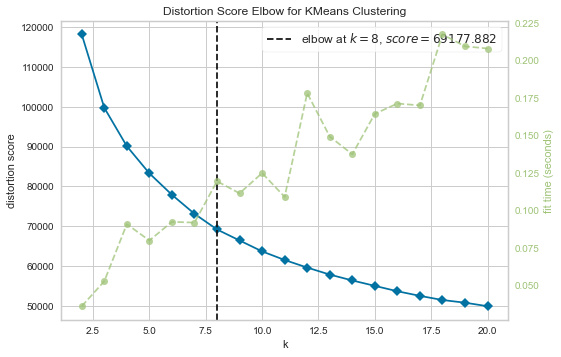

In [170]:
Elbow_M = KElbowVisualizer(KMeans(), k=20)
Elbow_M.fit(X)
Elbow_M.show();

Для корректной работы в дальнейшем предлагается внести ответ в качестве переменной

In [171]:
k_clust = 8 # сюда вставить ответ на задачу 8.2

## Кластеризация

Обучите модель `Kmeans` с количеством кластеров, полученном в задании 6.2, с помощью метода

In [172]:
kmean = KMeans(k_clust)
kmean.fit(X) 
labels = kmean.labels_

In [173]:
clusters = data.copy() # Коприрую исходный датафрейм
clusters['cluster'] = labels # В новый датафрейм добавляю столбец с результатами кластериации

,TENURE,BALANCE_range,PURCHASES_range,ONEOFF_PURCHASES_range,INSTALLMENTS_PURCHASES_range,CASH_ADVANCE_range,CREDIT_LIMIT_range,PAYMENTS_range,MINIMUM_PAYMENTS_range,BALANCE_FREQUENCY_range,PURCHASES_FREQUENCY_range,ONEOFF_PURCHASES_FREQUENCY_range,PURCHASES_INSTALLMENTS_FREQUENCY_range,CASH_ADVANCE_FREQUENCY_range,PRC_FULL_PAYMENT_range,PURCHASES_TRX_range,CASH_ADVANCE_TRX_range,cluster
0,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0,2
1,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1,3
2,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0,6
3,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1,6
4,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,6,1,1,0,1,0,2,1,1,10,10,0,9,0,5,2,0,5
8946,6,1,1,0,1,0,2,1,2,10,10,0,9,0,0,2,0,5
8947,6,1,1,0,1,0,2,1,1,9,9,0,7,0,3,1,0,5
8948,6,1,0,0,0,1,1,1,1,9,0,0,0,2,3,0,1,5


In [174]:
# Верхний вариант получения нового датафрейма с признаком меток классов мне нравится больше
# clusters = pd.concat([data, pd.DataFrame({'cluster': labels})], axis=1)
# clusters

## Анализ результатов кластеризации

In [175]:
clusters

,TENURE,BALANCE_range,PURCHASES_range,ONEOFF_PURCHASES_range,INSTALLMENTS_PURCHASES_range,CASH_ADVANCE_range,CREDIT_LIMIT_range,PAYMENTS_range,MINIMUM_PAYMENTS_range,BALANCE_FREQUENCY_range,PURCHASES_FREQUENCY_range,ONEOFF_PURCHASES_FREQUENCY_range,PURCHASES_INSTALLMENTS_FREQUENCY_range,CASH_ADVANCE_FREQUENCY_range,PRC_FULL_PAYMENT_range,PURCHASES_TRX_range,CASH_ADVANCE_TRX_range,cluster
0,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0,2
1,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1,3
2,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0,6
3,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1,6
4,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,6,1,1,0,1,0,2,1,1,10,10,0,9,0,5,2,0,5
8946,6,1,1,0,1,0,2,1,2,10,10,0,9,0,0,2,0,5
8947,6,1,1,0,1,0,2,1,1,9,9,0,7,0,3,1,0,5
8948,6,1,0,0,0,1,1,1,1,9,0,0,0,2,3,0,1,5


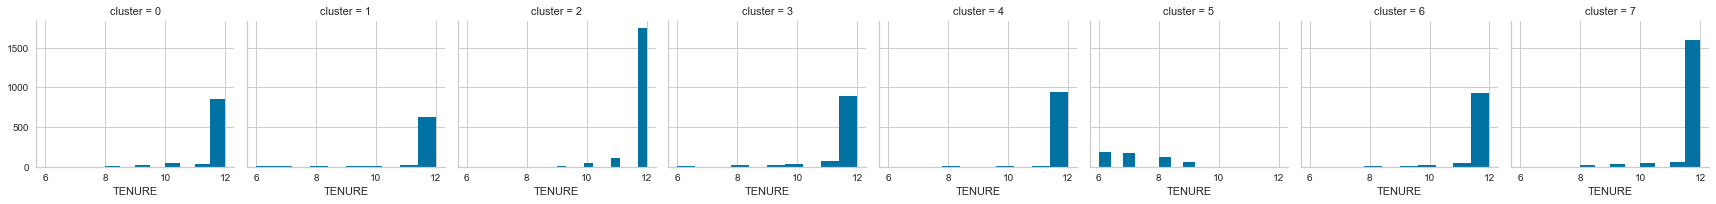

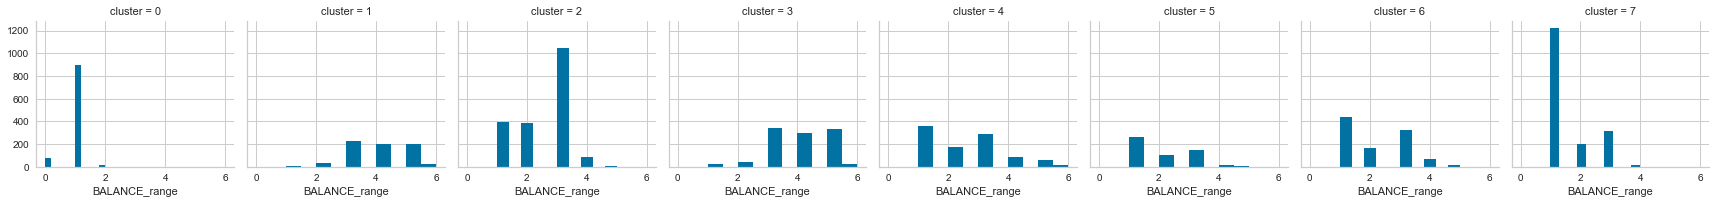

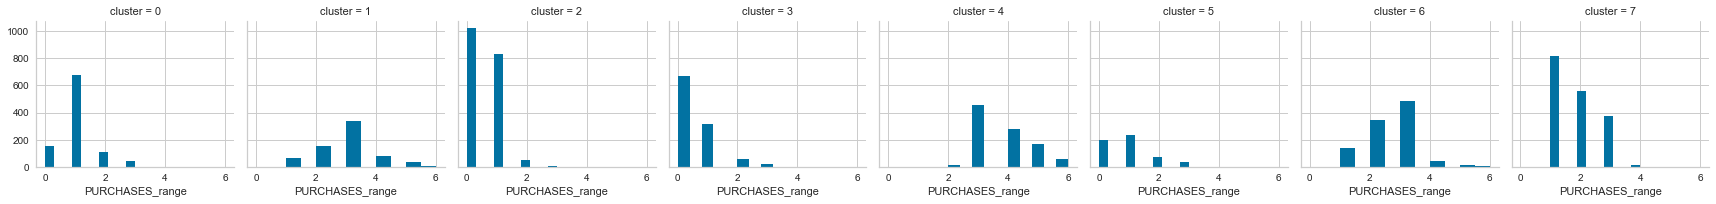

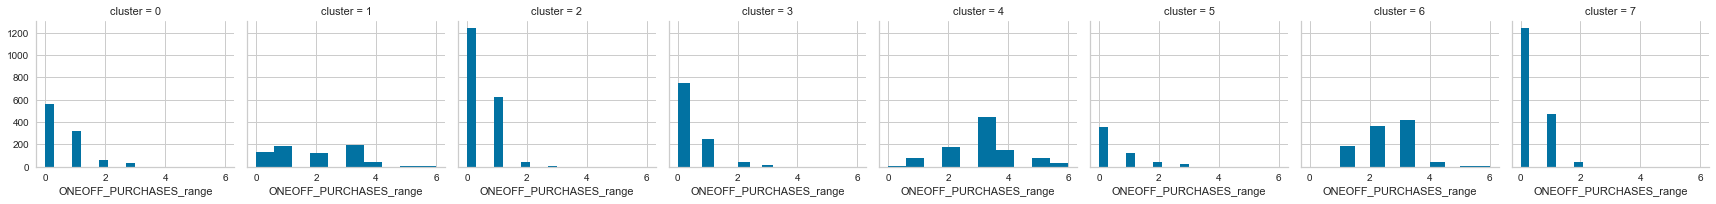

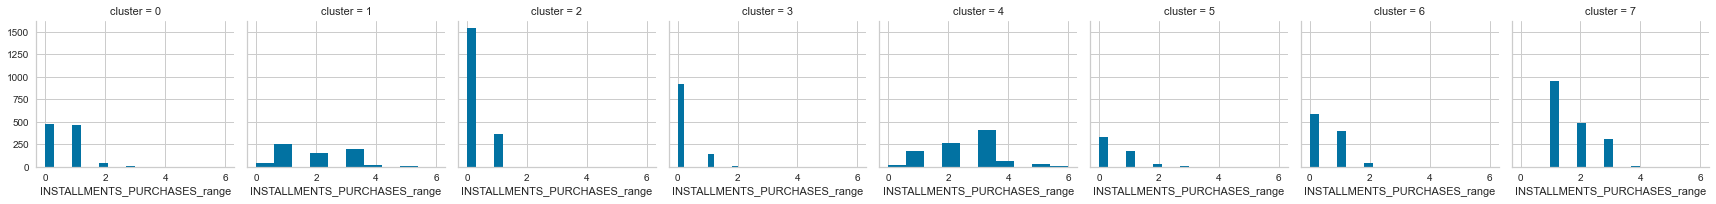

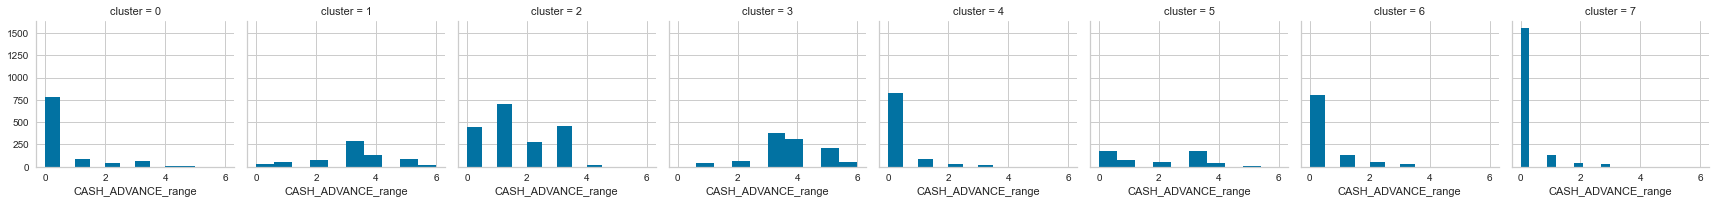

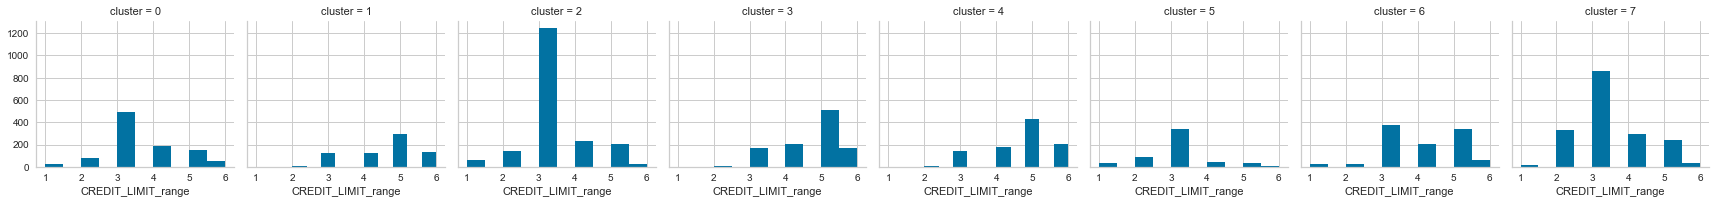

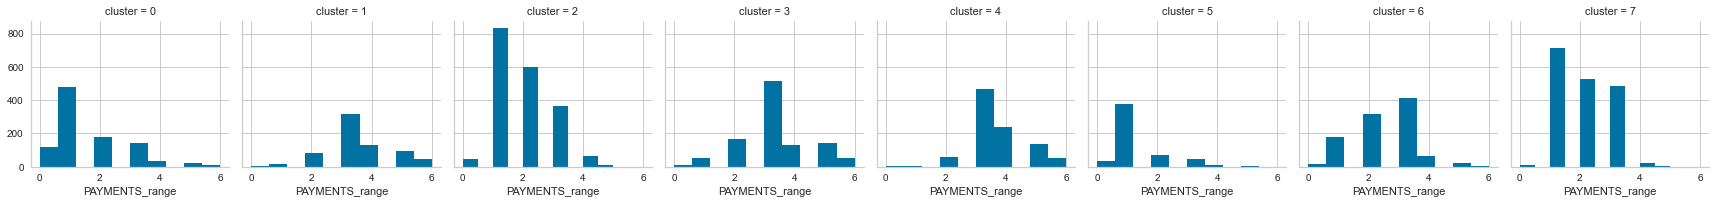

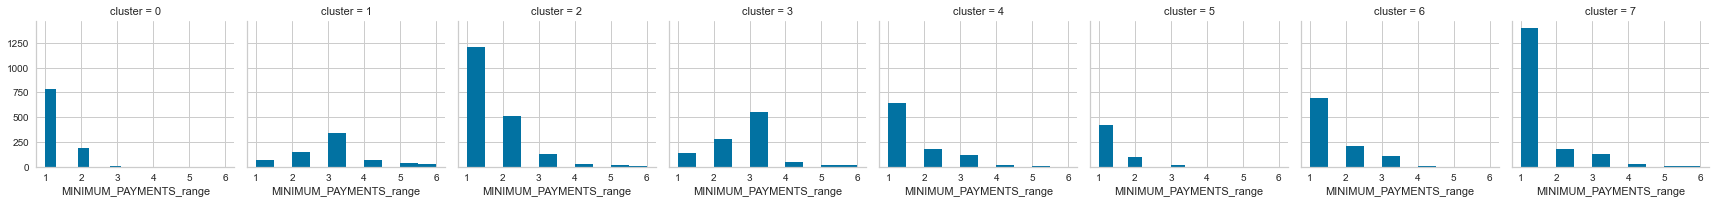

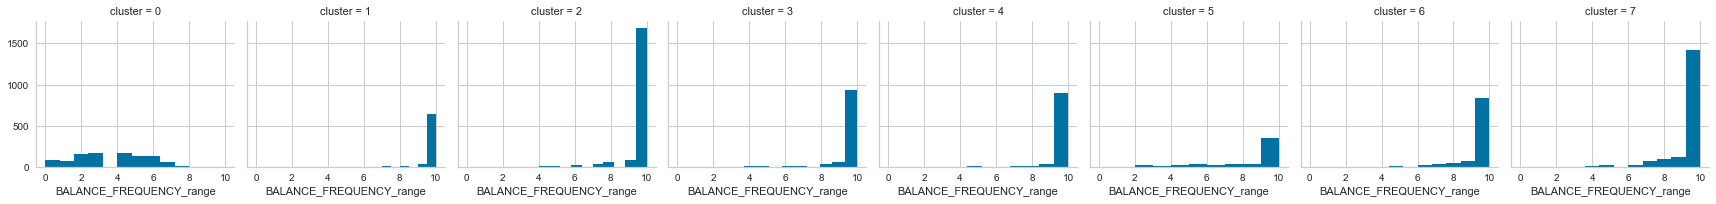

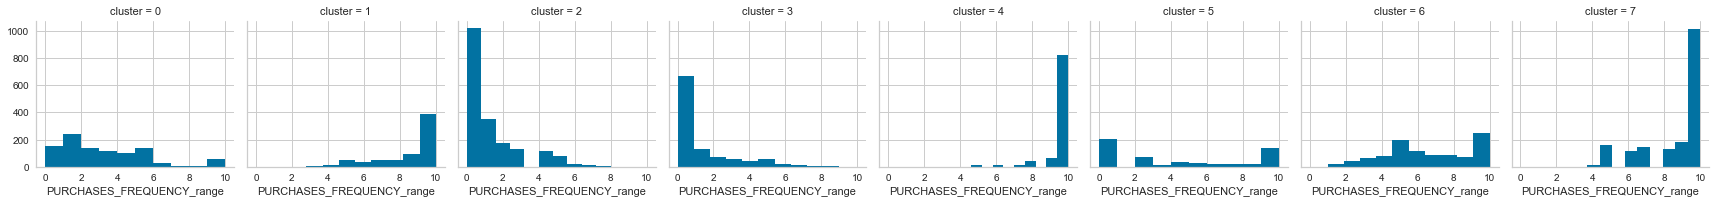

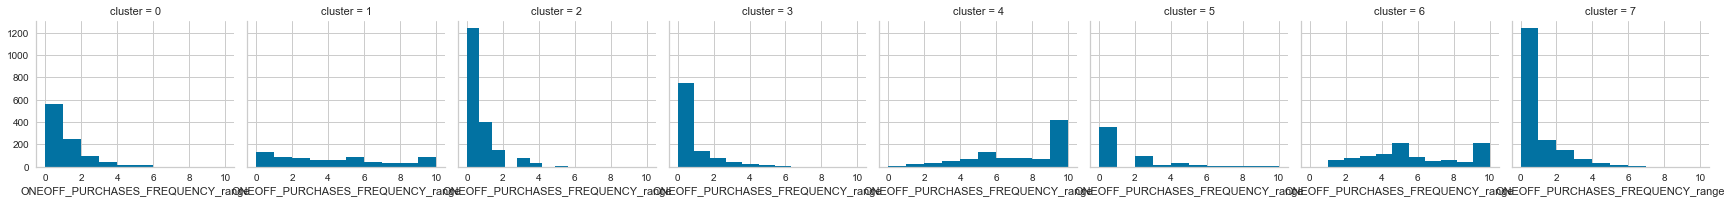

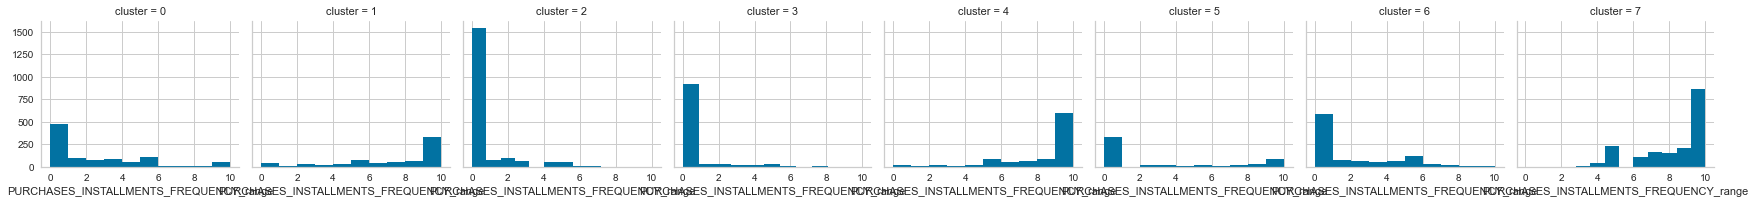

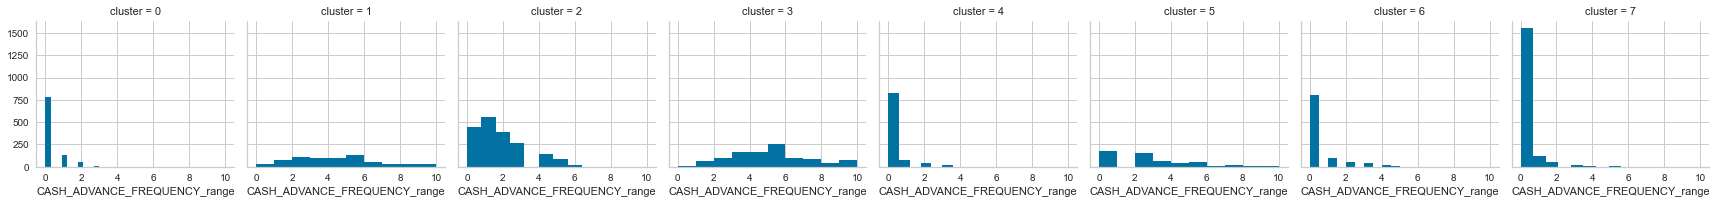

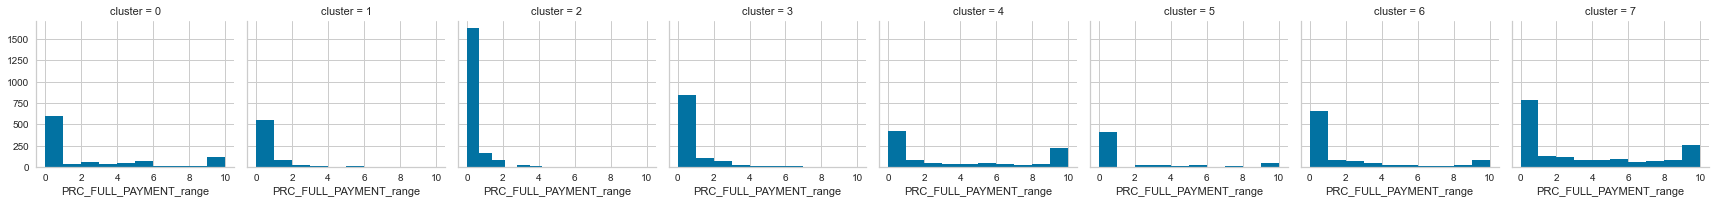

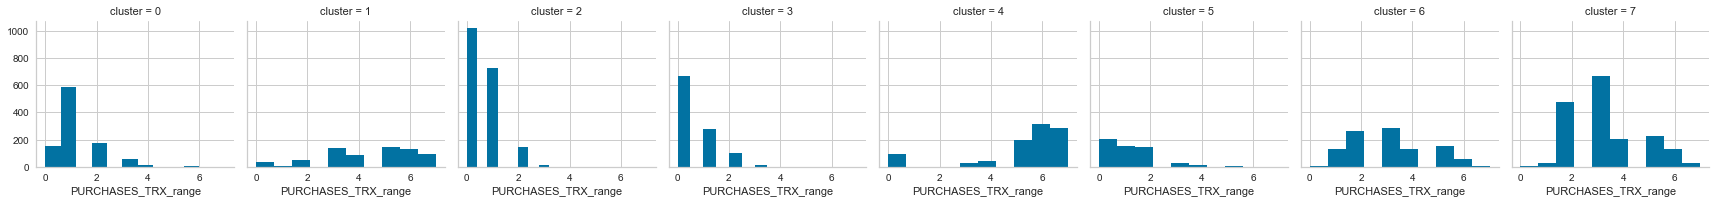

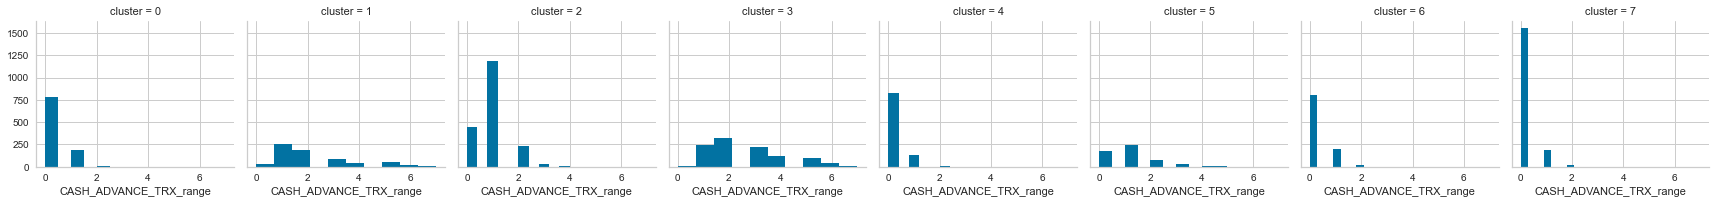

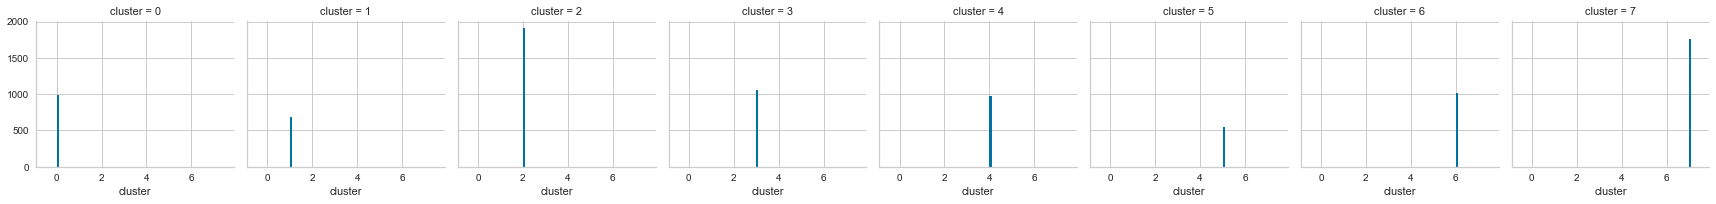

In [176]:
# раскомментируйте код для получения информации о распределениях признаков для каждого кластера
for c in clusters:
    grid = sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

#### Место для ваших выводов

Визуализируем кластеры, предварительно уменьшив разменость с помощью PCA до 2-х


In [177]:
pca = PCA(2)
pca.fit(X)
X_PCA = pca.transform(X)
X_PCA.shape

(8950, 2)

In [178]:
# Результат снижения размерности преобразую в датафрейм и добавляю столбец с метками кластеризации
pca_df = pd.DataFrame(X_PCA, columns=['x', 'y'])
pca_df['cluster'] = labels

In [179]:
pca_df

,x,y,cluster
0,-0.948378,-2.486936,2
1,-2.912299,2.172831,3
2,1.432313,0.645897,6
3,-0.740096,0.048017,6
4,-1.017031,-1.434761,2
...,...,...,...
8945,0.585497,-2.762742,5
8946,0.231480,-2.213528,5
8947,0.019907,-2.838943,5
8948,-2.735313,-2.616166,5


In [180]:
import plotly.express as px

In [181]:
fig = px.scatter(pca_df, 
                 x='x', 
                 y='y', 
                 color='cluster',
                 height=700,
                 width=1000,
                 title='Customers Segmentation based on their Credit Card usage behaviour.')

fig.update_layout(legend_orientation='h',
                  legend=dict(x=.5, xanchor='center'),
                  hovermode='x',
                  margin=dict(l=0, r=10, t=40, b=0))

fig.show()

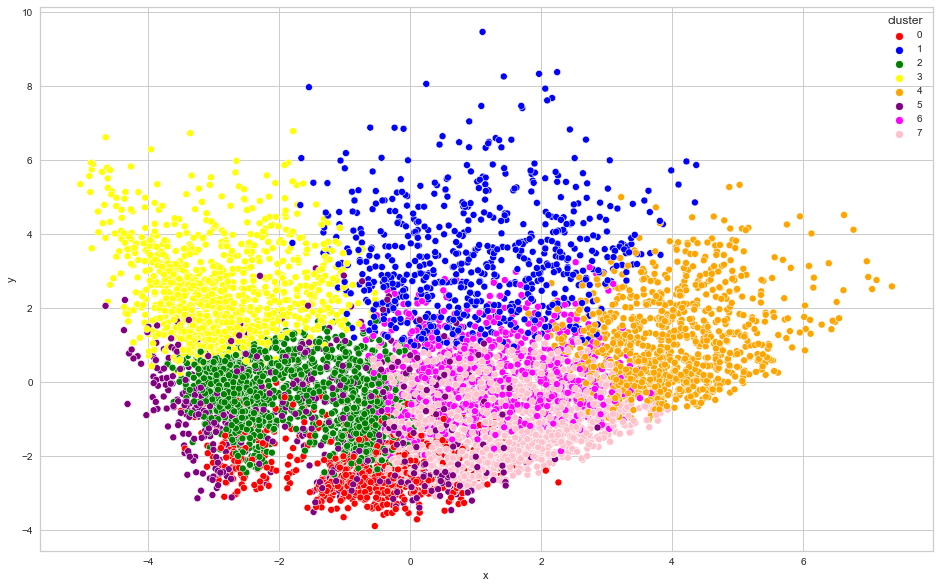

In [182]:
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'fuchsia', 'pink']
fig = plt.figure(figsize=(16, 10))
sns.scatterplot(data=pca_df, x='x', y='y', hue='cluster', palette=sns.color_palette(colors))
plt.show()

### Задача 8.3 
C помощью атрибута `explained_variance_ratio_` выведите процент объясненной дисперсии по обоим из осей. В качестве ответа внесите максимальное значение, округленное до десятых.

In [183]:
round(max(pca.explained_variance_ratio_), 1)

0.3

Эта визуализации мне вообще не понравилась, мои варианты выше намного лаконичнее

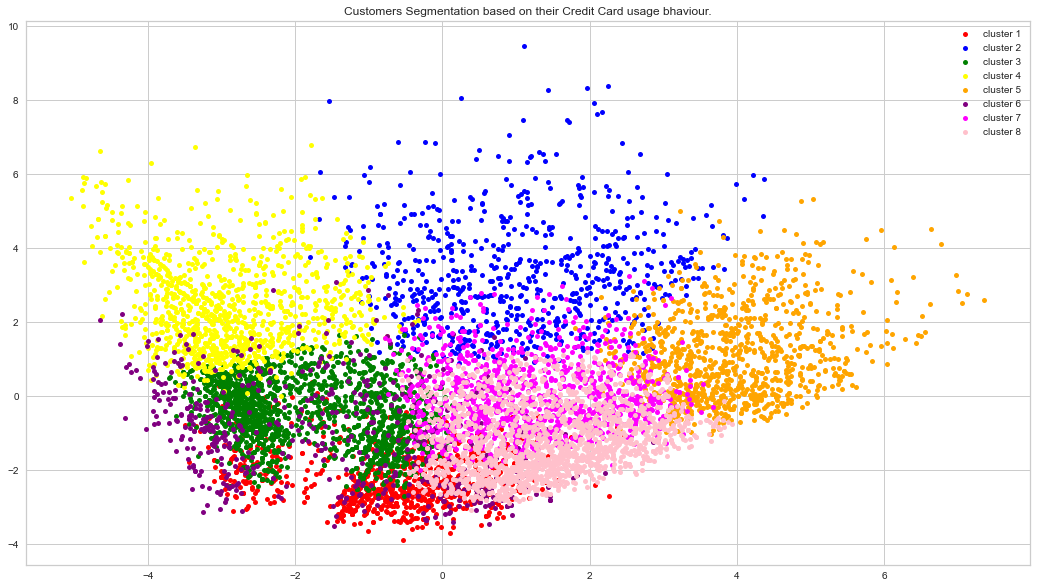

In [184]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5: 'purple',
          6: 'fuchsia',
          7: 'pink'}

names = {i: f'cluster {i+1}' for i in range(k_clust)}
  
df = pd.DataFrame({'x': x, 'y': y, 'label': labels})
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(18, 10))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name], label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
    
ax.legend()
ax.set_aspect('auto')
ax.set_title('Customers Segmentation based on their Credit Card usage bhaviour.')
plt.show()

Как мы видим, результат достаточно неочевидный, для более красивой визуализации вычислим косинусоидальное расстояние от исходных данных и применим к ним PCA.

Напомним, что косинусоидальное расстояние имеет вид: $$1 - \frac{u  v}{||u||_2||v||_2}$$
В модуле `sklearn.metrics.pairwise` реализовано вычитаемое в данной разнице в функции `cosine_similarity` предлагается реализовать функцию `cos_dist` косинусоидального расстояния на основе данной встроенной функции.

In [185]:
def cos_dist(X):
     return 1 - cosine_similarity(X) # здесь реализация

In [186]:
dist = cos_dist(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(8950, 2)

### Задача 8.4 
С помощью атрибута `explained_variance_ratio_` выведите процент объясненной дисперсии по обоим из осей после применения **косинусоидального значения**. В качестве ответа внесите максимальное значение, округленное до десятых.

In [188]:
round(max(pca.explained_variance_ratio_), 1)

0.6

In [189]:
# Результат снижения размерности преобразую в датафрейм и добавляю столбец с метками кластеризации
pca_df = pd.DataFrame(X_PCA, columns=['x', 'y'])
pca_df['cluster'] = labels

In [190]:
fig = px.scatter(pca_df, 
                 x='x', 
                 y='y', 
                 color='cluster',
                 height=700,
                 width=1000,
                 title='Customers Segmentation based on their Credit Card usage behaviour.')

fig.update_layout(legend_orientation='h',
                  legend=dict(x=.5, xanchor='center'),
                  hovermode='x',
                  margin=dict(l=0, r=10, t=40, b=0))

fig.show()

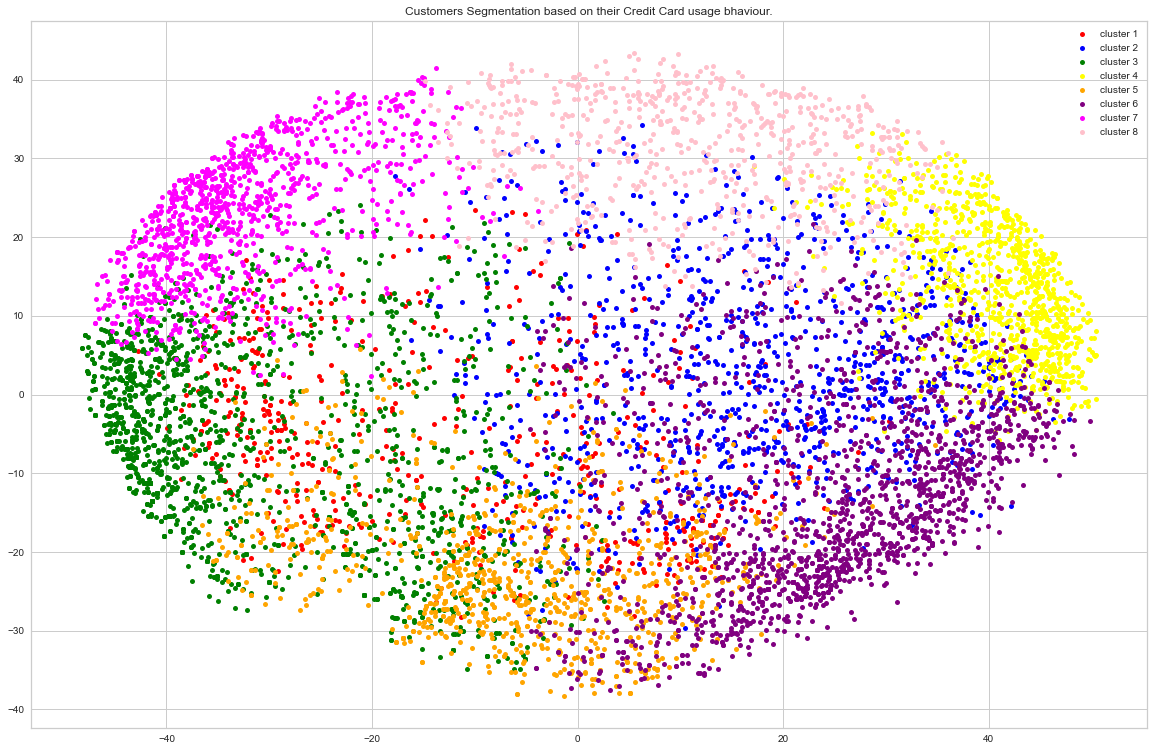

In [81]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple',
          6:'fuchsia',
          7:'pink'}

names = {i: f'cluster {i+1}' for i in range(k_clust)}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title('Customers Segmentation based on their Credit Card usage bhaviour.')
plt.show()

Визуализация получилась гораздо разборчивее!

### Задача 8.5
Что вы можете сказать о визуализации кластеров после преобразования с помощью косинусоидального расстояния:
* ничего не изменилось
* кластера стали сильнее различимы
* картина кластеров приняла форму эллипса
* картина кластеров  приняла форму квадрата


## Выводы
В данном задании мы на практике:
* определили оптимальное количество кластеров
* решили задачу кластеризации
* попробовали описать характерные зависимости для каждого кластера
* попробовали снизить размерность до 2-х мерной с помощью PCA
* преобразовали данные для лучшей визуализации с помощью косинусоидального расстояния.